<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn import metrics

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

Wayne's definitions: <br> 
<br>
Renovate: [Taken from dictionary.com] <br>
restore (something old, especially a building) to a good state of repair. some synonyms, recondition, reinvigorate, refurbish, restore, redevelop <br>

Fixed:
Renovation does not affect this characteristic in terms of the output values that will be reflected in the given dataset. eg. Basement space is a fixed characteristic,reconstruction of the house is required to change the value of basement space. <br>

Q1: Estimate value of homes using fixed characteristics. <br>
Methodology: <br>
Find out fixed characteristics according to above definition. <br>
EDA <br>
Feature engineering <br>
Modelling + Regularisation/Optimisation <br>
Cross Validation <br>

In [2]:
# Load dataset
house = pd.read_csv('./housing.csv')

In [3]:
# take a look at the dataset remove not residential rows
#house.head()
#house.info()
#house.columns
house['MSZoning'].value_counts()
to_drop = house[house['MSZoning'] == 'C (all)']
to_drop = list(to_drop.index)
house = house.drop(to_drop, axis = 0)
house['MSZoning'].value_counts()

RL    1151
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

In [4]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 81 columns):
Id               1450 non-null int64
MSSubClass       1450 non-null int64
MSZoning         1450 non-null object
LotFrontage      1191 non-null float64
LotArea          1450 non-null int64
Street           1450 non-null object
Alley            89 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
OverallQual      1450 non-null int64
OverallCond      1450 non-null int64
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
RoofStyle        1450 non-null object
RoofMatl         1450 non-null object
Exterior1st      1450 non-n

In [5]:
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
# Separating fixed characteristics from renovatable ones
all_col = list(house.columns)
fixed = house[['MSSubClass', 
         'MSZoning', 
         'LotFrontage',
         'LotArea',
         'Street',
         'Alley',
         'LotShape',
         'LandContour',
         'Utilities',
         'LotConfig',
         'LandSlope',
         'Neighborhood',
         'Condition1',
         'Condition2',
         'BldgType',
         'HouseStyle',
         'OverallCond',
         'YearBuilt',
         'YearRemodAdd',
         'MasVnrArea',
         'Foundation',
         'BsmtExposure',
         'BsmtFinSF1',
         'BsmtFinSF2',
         'TotalBsmtSF',
         'Electrical',
         '1stFlrSF',
         '2ndFlrSF',
         'GrLivArea',
         'BsmtFullBath',
         'FullBath',
         'BedroomAbvGr',
         'KitchenAbvGr',
         'TotRmsAbvGrd',
         'Fireplaces',
         'GarageType',
         'GarageYrBlt',
         'GarageCars',
         'GarageArea',
         'WoodDeckSF',
         'OpenPorchSF',
         'EnclosedPorch',
         '3SsnPorch',
         'ScreenPorch',
         'PoolArea',
         'MiscFeature',
         'MoSold',
         'YrSold',
         'SaleType',
         'SaleCondition']]
renovate = house.drop(fixed, axis =1)
print(len(fixed), len(renovate.columns))

1450 31


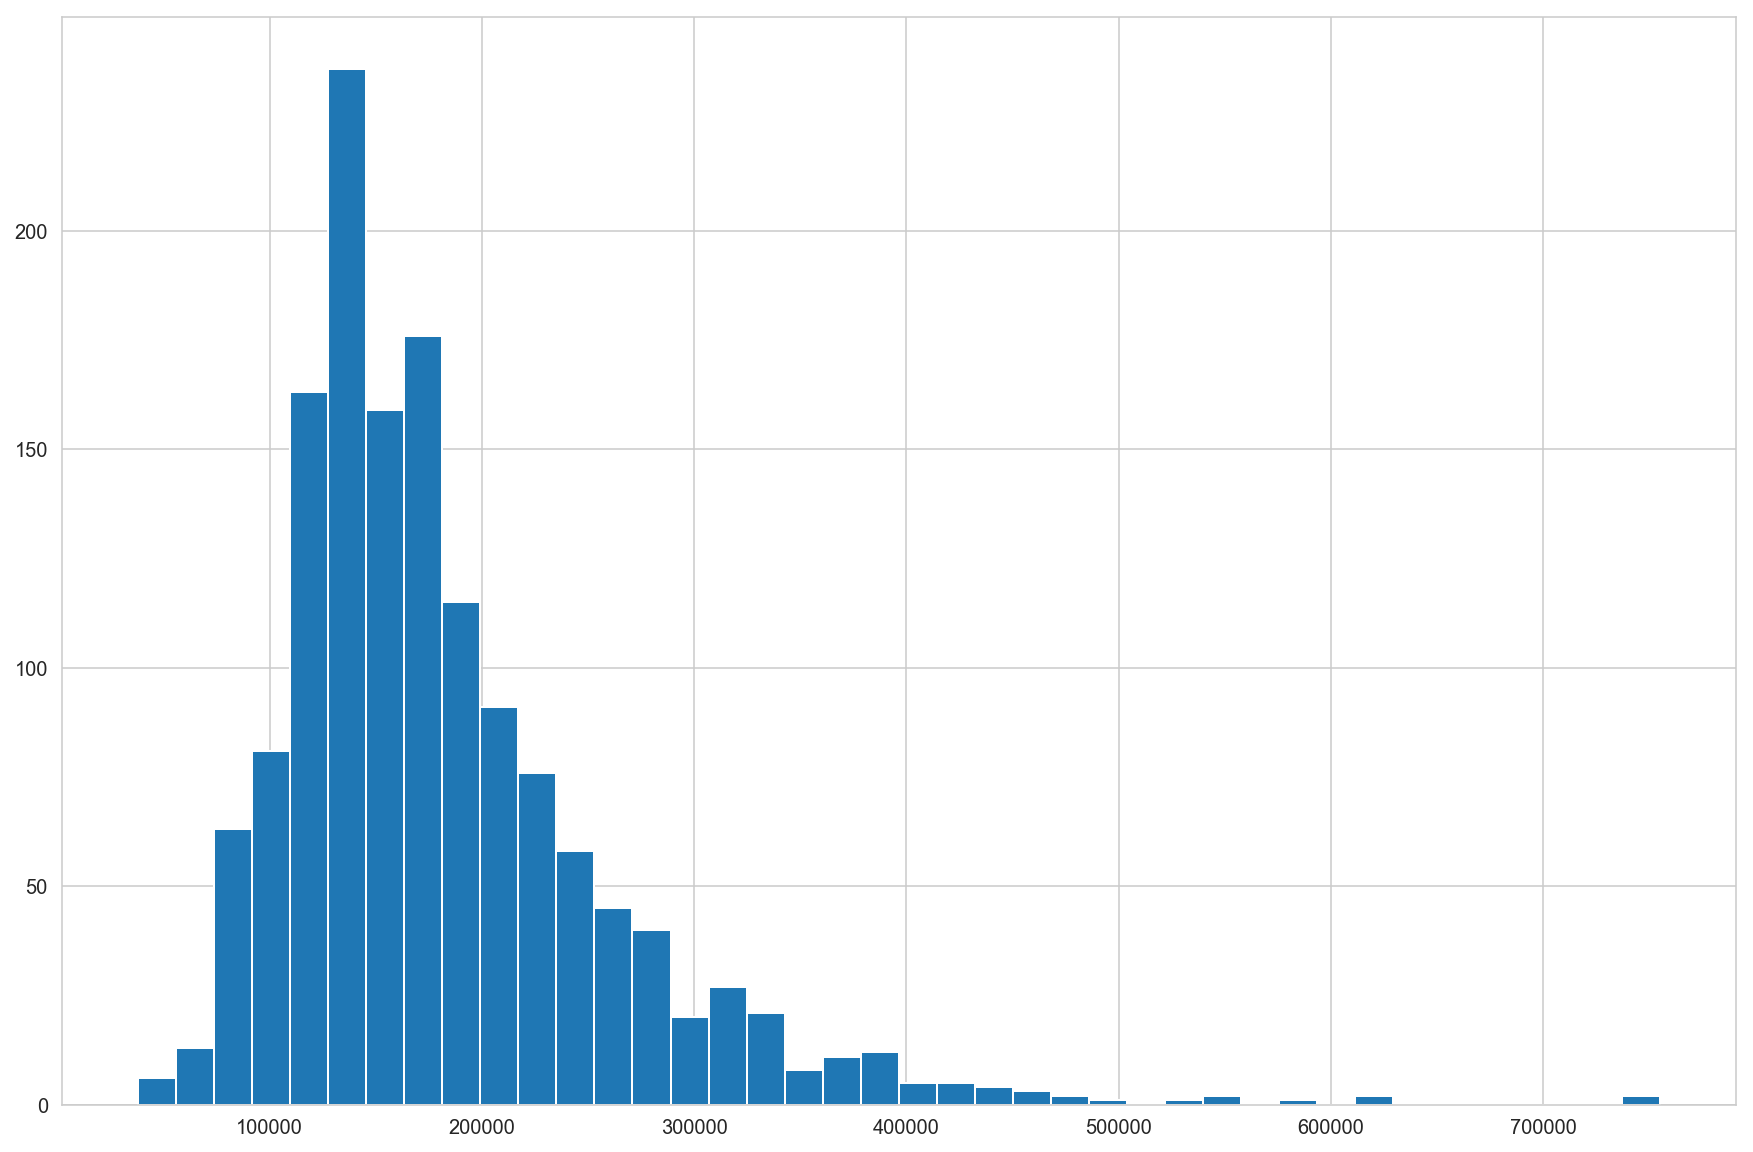

In [8]:
predictor = house[['SalePrice']]
predictor['SalePrice'].describe()
fig = plt.figure(figsize = (15, 10))
ax = plt.gca()
ax.hist(predictor['SalePrice'], bins = 40)
plt.show()

In [9]:
# categorical and continuous variable split for fixed and removing columns that dont make sense or have relation to each other
fixed.columns
fixed_cat = fixed[['MSSubClass', 
               'MSZoning', 
               'Street', 
               'Alley',
               'LotShape', 
               'LandContour', 
               'Utilities', 
               'LotConfig', 
               'LandSlope',
               'Neighborhood', 
               'Condition1',
               'Condition2', 
               'BldgType', 
               'HouseStyle',
               'OverallCond', 
               'YearBuilt', 
               'YearRemodAdd', 
               'Foundation',
               'BsmtExposure', 
               'Electrical',
               'BsmtFullBath', 
               'FullBath',
               'BedroomAbvGr', 
               'KitchenAbvGr', 
               'Fireplaces',
               'GarageType',
               'MiscFeature', 
               'MoSold', 
               'YrSold', 
               'SaleType', 
               'SaleCondition']]
continuous = fixed.drop(fixed_cat, axis =1)
#print(len(categorical.columns), len(continous.columns))
#Dropping TotRmsAbvGrd & GarageYrBlt, due to high correlation (0.8 and above) with 'GrLivArea' & 'YearBuilt'.
fixed_conti = continuous.drop(['TotRmsAbvGrd', 'GarageYrBlt'], axis = 1)

In [10]:
fixed_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 31 columns):
MSSubClass       1450 non-null int64
MSZoning         1450 non-null object
Street           1450 non-null object
Alley            89 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
OverallCond      1450 non-null int64
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
Foundation       1450 non-null object
BsmtExposure     1412 non-null object
Electrical       1449 non-null object
BsmtFullBath     1450 non-null int64
FullBath         1450 non-null int64
BedroomAbvGr     1450 non-null int64
KitchenAbvGr     1450 non-nu

In [11]:
# if 85% of the column and above has the same value or just 2 categories, the column will be binarized to either majority or not
# interior feature of houses should be dummified, not much sense comparing 1 kitchen houses to hses with more kitchens
fixed_cat['Alley'].value_counts() / len(fixed_cat['Alley'])
# Alley will be binarise to 1 = Alley and 0 = no Alley (93%)
fixed_cat.loc[:, 'Alley'] = [0 if x == np.nan else 1 for x in fixed_cat['Alley']]
fixed_cat['Utilities'].value_counts() / len(fixed_cat['Utilities'])
# will drop utilities column because almost 100% is AllPub (99.93%)
fixed_cat['LandContour'].value_counts() / len(fixed_cat['LandContour'])
# LandContour will be binarise to 1 = lvl and 0 = not lvl since 89% is lvl
fixed_cat.loc[:, 'LandContour'] = [1 if x == 'lvl' else 0 for x in fixed_cat['LandContour']]
fixed_cat['Street'].value_counts()
# Since street only consist of pave or grvl, binarise it to 1 = pave & grvl = 0
fixed_cat.loc[:, 'Street'] = [1 if x == 'Pave' else 0 for x in fixed_cat['Street']]
fixed_cat['LandSlope'].value_counts() / len(fixed_cat['LandSlope'])
# LandSlope will be binarised to gtl = 1, not gtl = 0 since gtl makes up the majority and the sev category only has less than 1% (0.89%)
fixed_cat.loc[:, 'LandSlope'] = [1 if x == 'gtl' else 0 for x in fixed_cat['LandSlope']]
fixed_cat['MiscFeature'].isnull().sum() / len(fixed_cat['MiscFeature'])
# MiscFeature will be converted to 1 = theres miscfeature 0 = no miscfeatures since nan makes up 96% of the column and we can still get data
# since the sale price will capture the value of the miscfeatures
fixed_cat.loc[:, 'MiscFeature'] = [0 if x == np.nan else 1 for x in fixed_cat['MiscFeature']]
fixed_cat['SaleCondition'].value_counts() / len(fixed_cat['SaleCondition'])
# SaleCondition will binarise to 1 = normal & not normal = 0
fixed_cat.loc[:, 'SaleCondition'] = [1 if x == 'normal' else 0 for x in fixed_cat['SaleCondition']]
fixed_cat['Condition1'].value_counts() / len(fixed_cat['Condition1'])
# Condition1 will binarise to 1 = normal(86%) & not normal = 0
fixed_cat.loc[:, 'Condition1'] = [1 if x == 'normal' else 0 for x in fixed_cat['Condition1']]
fixed_cat['Condition2'].value_counts() / len(fixed_cat['Condition2'])
# Condition2 will binarise to 1 = normal(98%) & not normal = 0
fixed_cat.loc[:, 'Condition2'] = [1 if x == 'normal' else 0 for x in fixed_cat['Condition2']]
fixed_cat['HouseStyle'].value_counts() / len(fixed_cat['HouseStyle'])
# Housestyle will be dummified
fixed_cat['OverallCond'].value_counts() / len(fixed_cat['OverallCond'])
# OverallCond will be dummified
fixed_cat['Electrical'].value_counts() / len(fixed_cat['Electrical'])
# Electrical will binarise to 1 = SBrkr(91%) & not SBrkr = 0
fixed_cat.loc[:, 'Electrical'] = [1 if x == 'SBrkr' else 0 for x in fixed_cat['Electrical']]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [12]:
fixed_conti.info()
fixed_conti.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 17 columns):
LotFrontage      1191 non-null float64
LotArea          1450 non-null int64
MasVnrArea       1442 non-null float64
BsmtFinSF1       1450 non-null int64
BsmtFinSF2       1450 non-null int64
TotalBsmtSF      1450 non-null int64
1stFlrSF         1450 non-null int64
2ndFlrSF         1450 non-null int64
GrLivArea        1450 non-null int64
GarageCars       1450 non-null int64
GarageArea       1450 non-null int64
WoodDeckSF       1450 non-null int64
OpenPorchSF      1450 non-null int64
EnclosedPorch    1450 non-null int64
3SsnPorch        1450 non-null int64
ScreenPorch      1450 non-null int64
PoolArea         1450 non-null int64
dtypes: float64(2), int64(15)
memory usage: 203.9 KB


,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea
0,65.0,8450,196.0,706,0,856,856,854,1710,2,548,0,61,0,0,0,0
1,80.0,9600,0.0,978,0,1262,1262,0,1262,2,460,298,0,0,0,0,0
2,68.0,11250,162.0,486,0,920,920,866,1786,2,608,0,42,0,0,0,0
3,60.0,9550,0.0,216,0,756,961,756,1717,3,642,0,35,272,0,0,0
4,84.0,14260,350.0,655,0,1145,1145,1053,2198,3,836,192,84,0,0,0,0


In [13]:
fixed_conti['LotFrontage'].isnull().sum()
# if its a null value, i assume it to not have this feature
fixed_conti.loc[:, 'LotFrontage'] = fixed_conti['LotFrontage'].replace(np.nan, 0)
fixed_conti['MasVnrArea'].isnull().sum()
# if its a null value, i assume it to not have this feature
fixed_conti.loc[:, 'MasVnrArea'] = fixed_conti['MasVnrArea'].replace(np.nan, 0)

In [14]:
def standardise(dataset):
    for col in dataset:
        dataset.loc[:, col] = (dataset[col] - np.mean(dataset[col])) / np.std(dataset[col])
    return dataset

In [15]:
standardised_conti = standardise(fixed_conti)
standardised_conti.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea
0,0.214936,-0.207202,0.508990,0.571765,-0.28973,-0.463287,-0.798869,1.159430,0.366307,0.308312,0.351444,-0.755487,0.221810,-0.354116,-0.116745,-0.270189,-0.068929
1,0.647114,-0.092303,-0.573359,1.167999,-0.28973,0.461424,0.251549,-0.795056,-0.487070,0.308312,-0.062451,1.618683,-0.713769,-0.354116,-0.116745,-0.270189,-0.068929
2,0.301372,0.072553,0.321235,0.089517,-0.28973,-0.317520,-0.633286,1.186894,0.511076,0.308312,0.633645,-0.755487,-0.069600,-0.354116,-0.116745,-0.270189,-0.068929
3,0.070877,-0.097298,-0.573359,-0.502333,-0.28973,-0.691049,-0.527209,0.935145,0.379641,1.650812,0.793559,-0.755487,-0.176961,4.118256,-0.116745,-0.270189,-0.068929
4,0.762361,0.373291,1.359407,0.459971,-0.28973,0.194943,-0.051158,1.614867,1.295879,1.650812,1.706010,0.774179,0.574569,-0.354116,-0.116745,-0.270189,-0.068929


In [16]:
fixed_cat.loc[:, 'MSSubClass'] = fixed_cat['MSSubClass'].astype(str)

In [17]:
binarised_cat = fixed_cat[['Alley', 'LandContour', 'Street', 'LandSlope', 'MiscFeature', 'SaleCondition', 'Condition1', 'Condition2', 'Electrical']]
binarised_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 9 columns):
Alley            1450 non-null int64
LandContour      1450 non-null int64
Street           1450 non-null int64
LandSlope        1450 non-null int64
MiscFeature      1450 non-null int64
SaleCondition    1450 non-null int64
Condition1       1450 non-null int64
Condition2       1450 non-null int64
Electrical       1450 non-null int64
dtypes: int64(9)
memory usage: 113.3 KB


In [18]:
for_dummying = fixed_cat.drop(binarised_cat, axis = 1)

In [19]:
def to_object(dataset):
    for col in dataset:
        dataset.loc[:, col] = dataset[col].astype(str)
    return dataset

In [20]:
for_dummying = to_object(for_dummying)

In [21]:
dummies = pd.get_dummies(for_dummying)
dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Columns: 318 entries, MSSubClass_120 to SaleType_WD
dtypes: uint8(318)
memory usage: 461.6 KB


In [22]:
print(len(binarised_cat),len(dummies))

1450 1450


In [23]:
bi_dummies_cat = pd.concat([binarised_cat, dummies], axis = 1, sort = False)
new_fixed_cat = pd.concat([standardised_conti, bi_dummies_cat], axis = 1, sort = True)
new_fixed_cat.head()
new_fixed_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Columns: 344 entries, LotFrontage to SaleType_WD
dtypes: float64(17), int64(9), uint8(318)
memory usage: 756.2 KB


In [24]:
# getting the correct data sets to 
y = predictor[['SalePrice']]
X = new_fixed_cat.values
dataset = pd.concat([predictor[['SalePrice']], new_fixed_cat], axis = 1, sort = True)
pre_2010_dataset = dataset[dataset['YrSold_2010'] == 0]
pre_2010_dataset['YrSold_2010'].value_counts()
post_2010_dataset = dataset[dataset['YrSold_2010'] != 0]
post_2010_dataset['YrSold_2010'].value_counts()
# X & y thats pre-2010 yr_built
X = pre_2010_dataset.drop('SalePrice', axis = 1)
y = pre_2010_dataset['SalePrice']
# X_holdup & y_holdup thats post-2010 yr_built
X_holdup = post_2010_dataset.drop('SalePrice', axis = 1)
y_holdup = post_2010_dataset['SalePrice']
print(len(X), len(y), len(X_holdup), len(y_holdup))

1278 1278 172 172


In [205]:
# Multi-Linear Reression model (No ridge or lasso yet) to see how well the model is if we just throw everything in
#print(len(X_train), len(y_train), len(X_test), len(y_test))
lr = LinearRegression()
model = lr.fit(X, y)
results_train = model.score(X, y)
print(results_train)
# 10-fold xval_score on test data
xval_score_train = cross_val_score(model, X_holdup, y_holdup, cv = 10)
print(xval_score_train, np.mean(xval_score_train), np.std(xval_score_train))
# results using everything is not gd 
# severe overfitting - large std deviations and low score of 0.4 when using pre2010 fitted model while doing gd on itself.

0.8865788744142631
[ 0.1697778   0.34501033  0.61843382  0.69208907 -1.01758669  0.77147449
  0.83697981  0.88665326  0.7365528   0.58880594] 0.4628190623914693 0.5360817739090964


In [207]:
# create ridge and lasso regularisation functions to find best alpha
def ridge_op(predictor_train, target_train, predictor_test, target_test, alpha):
    ridge_value = []
    for number in alpha:
        ridgereg = Ridge(alpha=number, normalize=True)
        ridgereg.fit(predictor_train, target_train)
        y_pred = ridgereg.predict(predictor_test)
        score = cross_val_score(ridgereg, predictor_test, target_test, cv = 10)
        ridge_value.append([number, np.mean(score), np.std(score)])
    ridge_value.sort(key=lambda x: x[1])
    return ridge_value[-1], ridgereg.coef_

In [208]:
def lasso_op(predictor_train, target_train, predictor_test, target_test, alpha):
    lasso_value = []
    for number in alpha:
        lassoreg = Lasso(alpha=number, max_iter = 10000, normalize=True)
        lassoreg.fit(predictor_train, target_train)
        y_pred = lassoreg.predict(predictor_test)
        score = cross_val_score(lassoreg, predictor_test, target_test, cv = 10)
        lasso_value.append([number, np.mean(score), np.std(score)])
    lasso_value.sort(key=lambda x: x[1])
    return lasso_value[-1], lassoreg.coef_

In [209]:
# using ridge:
alpha = np.arange(1.2, 1.5, 0.001)
best_alpha_r = ridge_op(X, y, X_holdup, y_holdup, alpha)
best_alpha_r

([1.307999999999988, 0.7384730524811223, 0.10541664747824742],
 array([  1384.23894985,   1969.05311311,   4006.87765248,   3074.81305657,
           231.0529539 ,   4956.25660451,   5546.23817703,   3264.89918147,
          6755.19545146,   4901.37964321,   4318.13720752,   2583.19541683,
          1879.31728549,   -332.6861106 ,    597.31460948,   1731.57961519,
           512.16964031,      0.        ,      0.        ,   5679.81212276,
             0.        ,      0.        ,      0.        ,      0.        ,
             0.        ,   1998.97417041,  -1165.32803066,  -4876.42506903,
         -5086.44861522,  -2888.71102671,    999.69637616,  -7044.48613703,
          -861.20827416,  -1229.58708728,  -1411.12963827,   4772.86596566,
           789.34406943,   3606.06995226,  -2921.88514594,  -4499.03219841,
         -3502.64083031,   3229.98345645,  -2743.17570121,   2468.78865007,
         -3966.46857807,   1666.92058704,   5599.97736999, -10261.80960163,
         -1891.75865252, 

In [ ]:
# using lasso:
alpha = np.arange(70, 100, 0.01)
best_alpha_l = lasso_op(X, y, X_holdup, y_holdup, alpha)
best_alpha_l

Ridge seems to do better with a higher average score of 0.738 and lower standard deviations for a 10 fold cross validation. <br>
Next steps will be: <br>
1. try using lasso to eliminate some values to create a new set of predictor matrix and fit it into a ridge model <br>
2. use RFECV to find the best features for new pred matrix <br>
3. use KBestSlection <br>

In [107]:
# drop some columns that zero_ed by Lasso.
lasso = Lasso(alpha = 63.45999999999931)
model = lasso.fit(X_train, y_train)
features = pd.DataFrame(X_train.columns, columns = ['feature'])
features['coefficient'] = list(model.coef_)
features
# 1st FlrSF is zeroed which by common sense should not be, so I will drop Lasso as a means of feature selection 
# I dont think we should use Lasso modelling as a way to eliminate features... 
# maybe after we manually choose using domain knowledge and common sense using lasso to eliminate lower coefiicient features will mke more sense

,feature,coefficient
0,LotFrontage,-480.420625
1,LotArea,4624.366865
2,MasVnrArea,171.241330
3,BsmtFinSF1,4066.389319
4,BsmtFinSF2,547.030380
5,TotalBsmtSF,4761.562239
6,1stFlrSF,0.000000
7,2ndFlrSF,1646.353955
8,GrLivArea,29861.517001
9,GarageCars,16577.203263


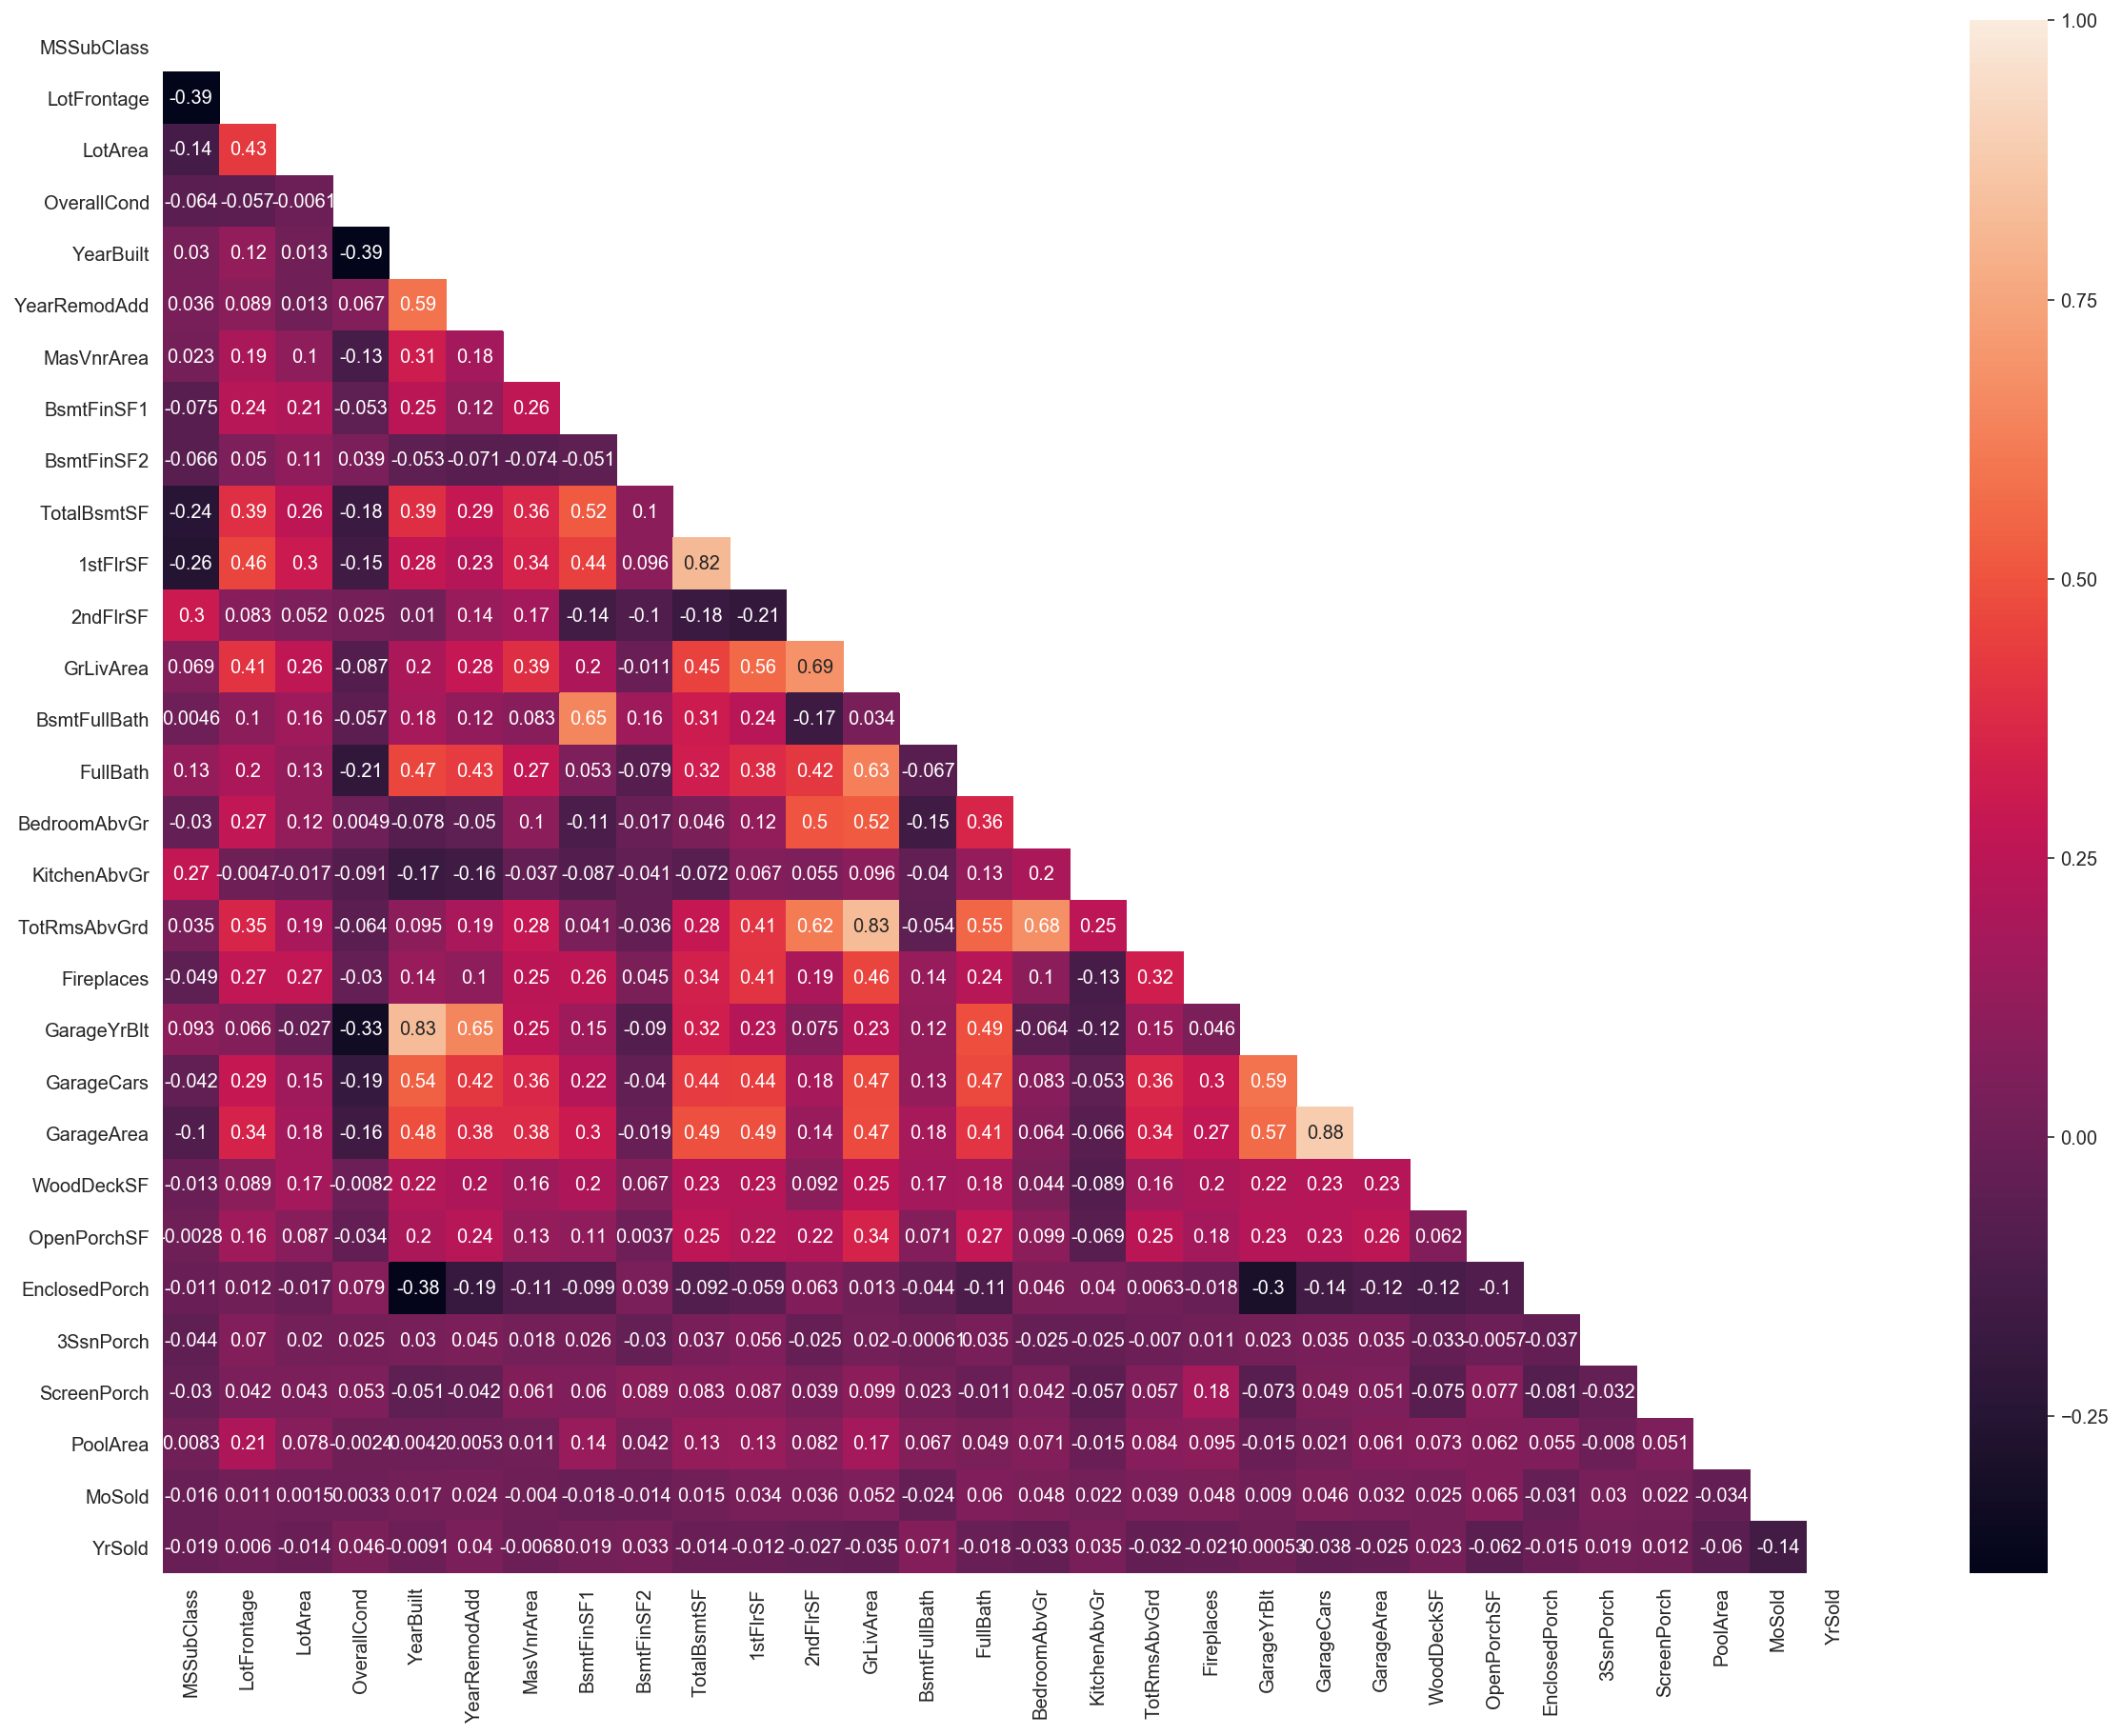

In [169]:
# Take a look at the correlation between fixed variables
# from heatmap, some features with high correlation can be dropped to prevent multicollinearity
# drop columns that I deem should not be useful
fig = plt.figure(figsize = (20,15))
mask = np.zeros_like(fixed.corr(), dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(fixed.corr(), mask = mask, annot = True)
plt.show()
to_drop = ['GarageYrBlt', 
           'GarageCars', 
           'YearBuilt', 
           'MoSold', 
           'YrSold', 
           'Street', 
           'Alley', 
           'LandSlope', 
           'LandContour', 
           'Electrical', 
           'YearRemodAdd', 
           'LotShape', 
           'LotConfig',
           'MSSubClass',
           'BsmtFinSF1',
           'BsmtFinSF2',
           'TotRmsAbvGrd',
           'GrLivArea']

In [185]:
new_fixed = fixed.drop(to_drop, axis = 1)

In [186]:
# We can combine the 1stFlrSF, 2ndFltSF, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch,3SsnPorch & ScreenPorch to get the overall space of a house
new_fixed['overallhsesf'] = new_fixed['1stFlrSF'] \
                          + new_fixed['2ndFlrSF'] \
                          + new_fixed['GarageArea'] \
                          + new_fixed['WoodDeckSF'] \
                          + new_fixed['OpenPorchSF'] \
                          + new_fixed['EnclosedPorch'] \
                          + new_fixed['3SsnPorch'] \
                          + new_fixed['ScreenPorch']
new_fixed['overallhsesf']
new_fixed = new_fixed.drop(['Utilities', 
                            '1stFlrSF', 
                            '2ndFlrSF', 
                            'GarageArea', 
                            'WoodDeckSF', 
                            'OpenPorchSF', 
                            'EnclosedPorch', 
                            '3SsnPorch', 
                            'ScreenPorch'], axis = 1)
len(new_fixed.columns)

24

In [190]:
categorical = fixed[['MSZoning',
               'Neighborhood', 
               'Condition1',
               'Condition2', 
               'BldgType', 
               'HouseStyle',
               'OverallCond', 
               'Foundation',
               'BsmtExposure', 
               'BsmtFullBath', 
               'FullBath',
               'BedroomAbvGr', 
               'KitchenAbvGr', 
               'Fireplaces',
               'GarageType',
               'MiscFeature',  
               'SaleType', 
               'SaleCondition']]
continuous = new_fixed.drop(categorical, axis = 1)

24


In [198]:
for_bi = categorical[['MiscFeature', 'SaleCondition', 'Condition1', 'Condition2']]
for_bi.loc[:, 'MiscFeature'] = [0 if x == np.nan else 1 for x in for_bi['MiscFeature']]
for_bi.loc[:, 'SaleCondition'] = [1 if x == 'normal' else 0 for x in for_bi['SaleCondition']]
for_bi.loc[:, 'Condition1'] = [1 if x == 'normal' else 0 for x in for_bi['Condition1']]
for_bi.loc[:, 'Condition2'] = [1 if x == 'normal' else 0 for x in for_bi['Condition2']]
for_dummy = categorical.drop(for_bi, axis = 1)
dummies = pd.get_dummies(for_dummy)
bi_dummy = pd.concat([for_bi, dummies], axis = 1, sort = True)
bi_dummy.head()

,MiscFeature,SaleCondition,Condition1,Condition2,OverallCond,BsmtFullBath,FullBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,...,GarageType_Detchd,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,1,0,0,0,5,1,2,3,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,8,0,2,3,1,1,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,5,1,2,3,1,1,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,5,1,1,3,1,1,...,1,0,0,0,0,0,0,0,0,1
4,1,0,0,0,5,1,2,4,1,1,...,0,0,0,0,0,0,0,0,0,1


In [204]:
# datasets that went thru first round of feature engineering
std_conti = standardise(continuous)
std_conti.head()
new_fixed_features = pd.concat([std_conti, bi_dummy], axis = 1, sort = True)
pre_2010 = new_fixed_features[dataset['YrSold_2010'] == 0]
post_2010 = new_fixed_features[dataset['YrSold_2010'] != 0]

1450


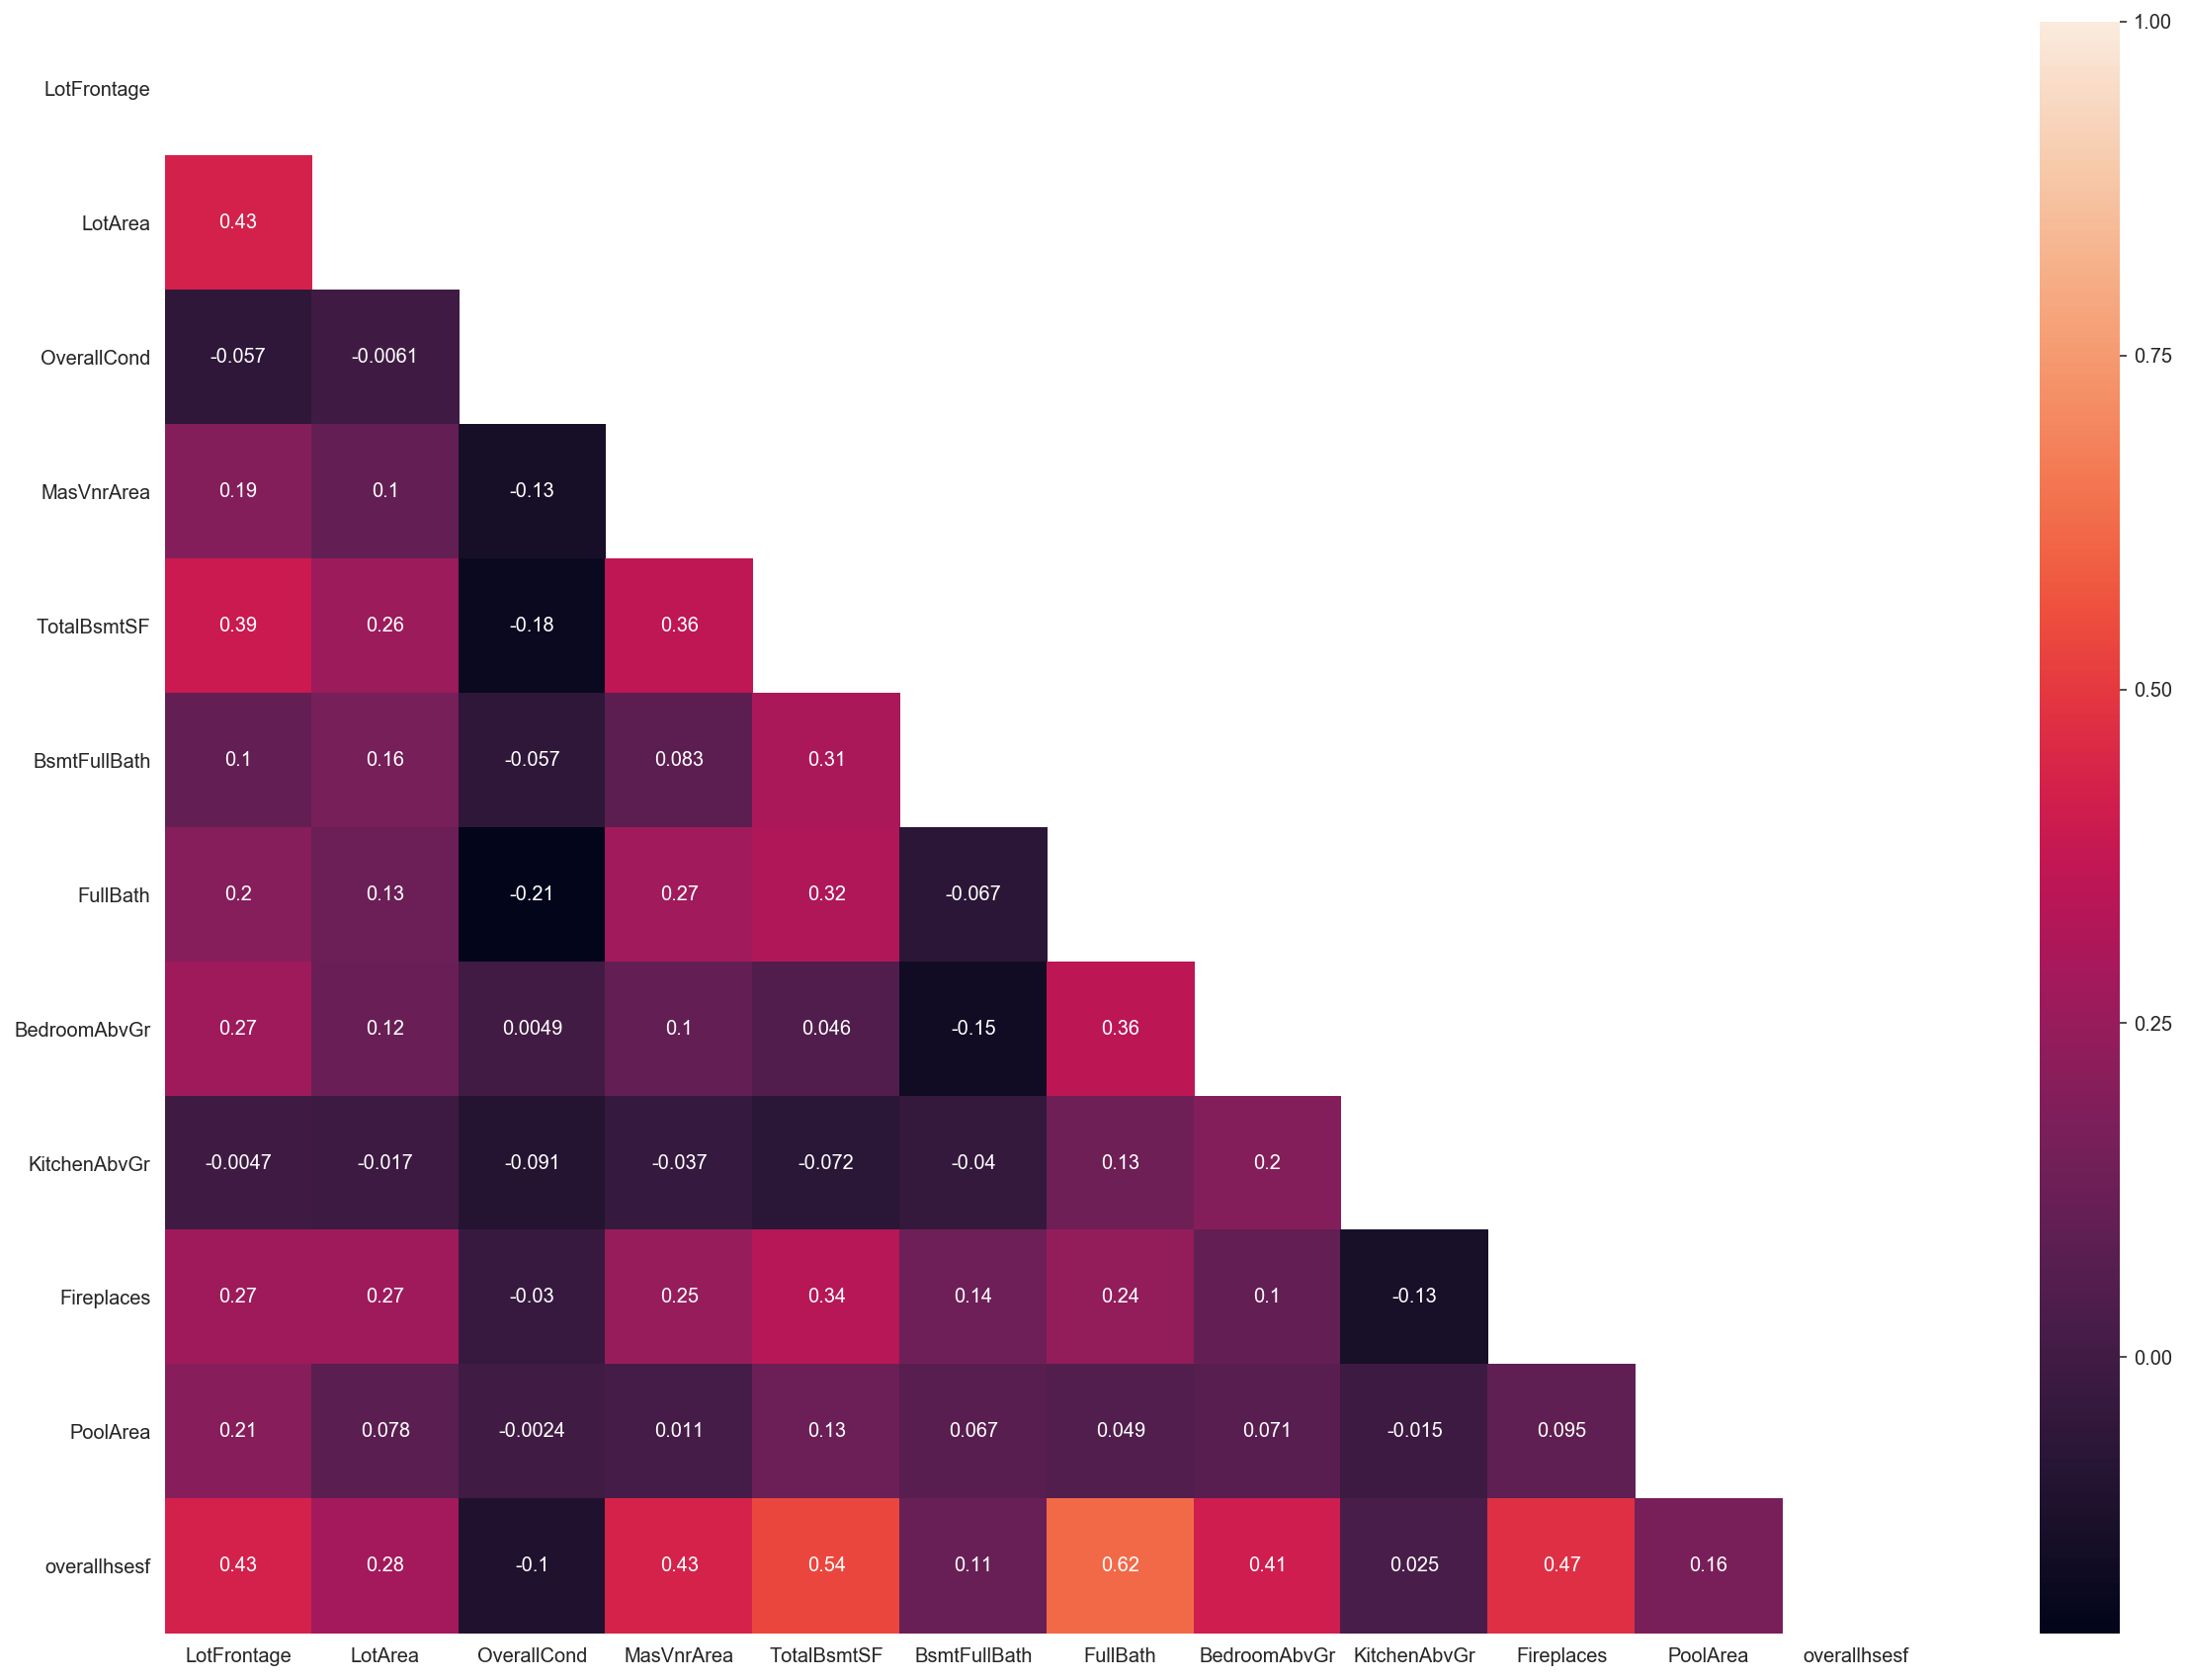

In [172]:
fig = plt.figure(figsize = (20,15))
mask = np.zeros_like(new_fixed.corr(), dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(new_fixed.corr(), mask = mask, annot = True)
plt.show()

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [30]:
# A:

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [31]:
# A: